<a href="https://colab.research.google.com/github/Pranav-Vishwanatham/Picture_captioning/blob/main/CAPTIONING_A_PICTURE_USING_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers.merge import add
from keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt
import cv2

In [ ]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:   # removeING short descriptions
            continue
        img_id = token[0].split('.')[0] # name of the image
        img_des = token[1]              # description of the image
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

text = open('/content/drive/My Drive/Project/Flickr8k_text/Flickr8k.token.txt', 'r', encoding = 'utf-8').read()
descriptions = load_description(text)
print(text[:482])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting



In [ ]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:

descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [ ]:
import string
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [ ]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocabulary = to_vocab(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [ ]:
from pickle import dump, load
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [ ]:
import glob
images = r'/content/drive/My Drive/Project/Images/'
# Creating a list of all image names in the directory
img = glob.glob(images + '*.jpg')
print('Images loaded: %d' % len(img))
train_path = r'/content/drive/My Drive/Project/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")

train_img = []  # list of all images in training set
for im in img:
    if(im[len(images):] in train_images):
        train_img.append(im)
print('Training Dataset loaded: %d' % len(train_img))
test_images_file = r'/content/drive/My Drive/Project/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []
for i in img:
    if i[len(images):] in test_images:
        test_img.append(i)
print('Testing Dataset loaded: %d' % len(test_img))

Images loaded: 8091
Training Dataset loaded: 6000
Testing Dataset loaded: 1000


In [ ]:
# loading descriptions of training set in a dictionary
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key+'.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
for i in train_descriptions['1001773457_577c3a7d70']:
    print(i)

startseq black dog and spotted dog are fighting endseq
startseq black dog and tricolored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


In [ ]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_img(img_path):
    # inception v3 img in 299 * 299 * 3
    img = load_img(img_path, target_size = (299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec

base_model = InceptionV3(weights = 'imagenet')
model = Model(base_model.input, base_model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# running the encode function on all train images and store the feature vectors in a list
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
    print(encoding_train[img[len(images):]])

Streaming output truncated to the last 5000 lines.
[0.19749829 0.9307251  0.1250953  ... 0.18376479 0.5342544  0.3746436 ]
[0.28844252 0.08203344 0.66530025 ... 0.33067173 1.1278524  0.32552576]
[0.22209206 0.07051607 0.07001394 ... 0.28303206 0.13243103 0.88748264]
[0.71973187 0.31092134 0.68403447 ... 1.0271618  0.440573   0.2931941 ]
[0.37926453 0.11570265 0.21218482 ... 0.28709787 0.25589406 0.04243068]
[0.3260863  0.26419157 0.20134597 ... 0.33043134 0.74329734 0.18420969]
[0.54385066 1.3489821  0.20836842 ... 0.10610403 0.86232185 1.049516  ]
[0.36371425 0.33066392 0.9225     ... 0.41990793 0.775223   0.2068331 ]
[0.2483204  0.38045692 0.07711169 ... 0.47295815 0.10039263 0.6511363 ]
[0.69193596 0.17327012 0.55605584 ... 0.10538118 0.05883605 0.07474674]
[0.97349143 0.7435857  2.5119586  ... 0.20722201 1.4440453  0.01408406]
[0.5133358  0.23755898 0.53827983 ... 1.1797085  0.16978005 0.09827331]
[0.31105304 0.26542705 0.6972862  ... 0.28389502 0.00492011 0.79820764]
[0.37410533 0

In [ ]:
with open(r"/content/drive/My Drive/Project/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [ ]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
    print(encoding_test[img[len(images):]])

[0.00621018 0.09716953 0.39959657 ... 0.16787468 0.31095093 0.7137471 ]
[0.04891451 0.30756727 0.05796804 ... 0.0780591  0.4497678  0.01106733]
[0.5713104  0.2005522  0.82026815 ... 0.06107275 0.6412676  1.0391735 ]
[1.051467   0.2450368  0.57877576 ... 0.6520215  0.7892639  0.12518531]
[0.12316729 0.2127547  0.20689929 ... 0.5095806  0.04995389 0.01672028]
[0.14799626 0.187049   1.3329043  ... 0.24071488 0.89806813 1.0376179 ]
[0.3294788  0.64042753 0.63190055 ... 0.3040309  0.812168   0.30155513]
[0.57478315 0.6627989  0.6558033  ... 0.04840264 0.12460703 0.37982494]
[0.24773306 0.4936847  0.2976948  ... 0.77885497 0.97868073 0.0011582 ]
[0.9227387  0.575385   1.1785581  ... 0.30399263 0.18183392 0.14773908]
[0.1401075  0.06518605 0.29869515 ... 0.49725515 0.9732117  0.20800522]
[0.44387114 0.7640153  2.385889   ... 0.42852953 0.3575816  0.04884192]
[0.56066996 0.07099761 1.0457904  ... 0.60064584 0.17933914 0.27493167]
[0.38419986 0.12578519 0.46273822 ... 0.52741814 0.23804231 0.43

In [ ]:
with open(r"/content/drive/My Drive/Project/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [ ]:
from pickle import load
train_features = load(open(r"/content/drive/My Drive/Project/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
print('All trainable captions : ',len(all_train_captions))

All trainable captions :  30000


In [ ]:
# considering only words which occur atleast 10 times
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
# word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

max_length = max(len(des.split()) for des in all_train_captions)
print('Description Length: %d' % max_length)
vocab_size = len(ixtoword) + 1
print('Vocabulary Size: %d' % vocab_size)

Description Length: 34
Vocabulary Size: 1652


In [ ]:

X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)



In [ ]:
# loading glove vectors for embedding layer
embeddings_index = {}
golve_path =r"/content/drive/My Drive/Project/glove/glove.6B.200d.txt"
glove = open(golve_path, 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices

In [ ]:
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

In [ ]:
ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

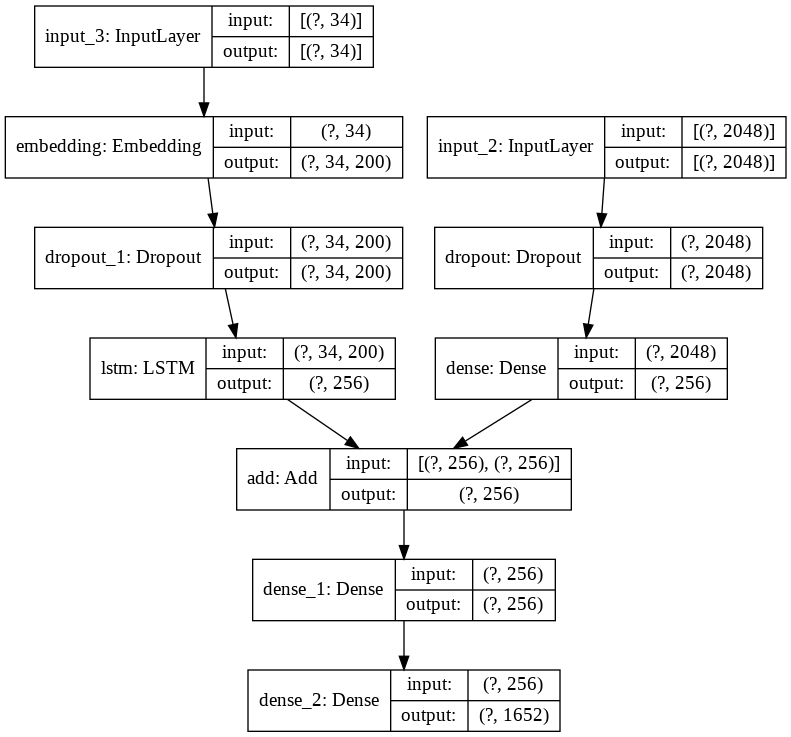

In [ ]:
import keras
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
hist=model.fit([X1, X2], y, epochs = 300, batch_size = 256)

Epoch 1/300
1142/1142 [==============================] - 100s 88ms/step - loss: 3.8987
Epoch 2/300
1142/1142 [==============================] - 100s 87ms/step - loss: 3.1541
Epoch 3/300
1142/1142 [==============================] - 100s 87ms/step - loss: 2.9180
Epoch 4/300
1142/1142 [==============================] - 100s 87ms/step - loss: 2.7628
Epoch 5/300
1142/1142 [==============================] - 100s 88ms/step - loss: 2.6471
Epoch 6/300
1142/1142 [==============================] - 100s 88ms/step - loss: 2.5506
Epoch 7/300
1142/1142 [==============================] - 100s 88ms/step - loss: 2.4694
Epoch 8/300
1142/1142 [==============================] - 100s 88ms/step - loss: 2.4009
Epoch 9/300
1142/1142 [==============================] - 100s 88ms/step - loss: 2.3424
Epoch 10/300
1142/1142 [==============================] - 101s 88ms/step - loss: 2.2883
Epoch 11/300
1142/1142 [==============================] - 101s 88ms/step - loss: 2.2405
Epoch 12/300
1142/1142 [=================

In [ ]:
model.save(r'/content/drive/My Drive/Project/mymodel.h5')

In [ ]:
from keras.models import load_model
model1=load_model(r'/content/drive/My Drive/Project/mymodel.h5')

In [ ]:
images=r'/content/drive/My Drive/Project/Images/'

In [ ]:
with open(r"/content/drive/My Drive/Project/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def caption_predictor(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model1.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

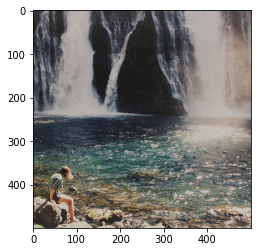

Predicted Caption   :  person sits on rock by fall
BLEU Score Average  :  52.59


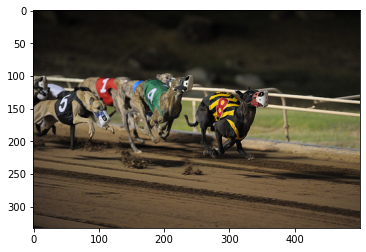

Predicted Caption   :  dogs racing on track
BLEU Score Average  :  60.00


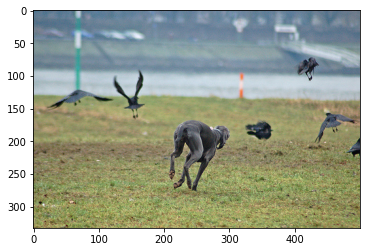

Predicted Caption   :  black dog runs across the grass
BLEU Score Average  :  48.39


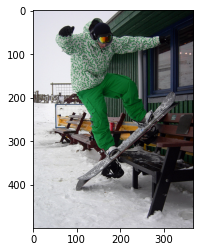

Predicted Caption   :  person in red coat rollerskating down white camera
BLEU Score Average  :  29.20


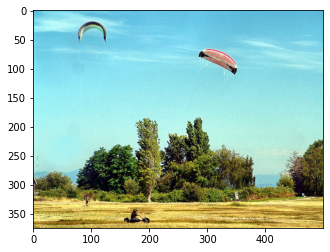

Predicted Caption   :  two people fly through the air in the woods
BLEU Score Average  :  31.16


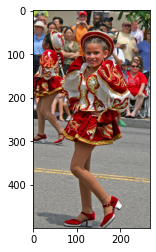

Predicted Caption   :  girl in red dress and heels dancing in parade
BLEU Score Average  :  27.56


In [ ]:
for i in range(4,10):
    pic = list(encoding_test.keys())[i]
    te = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    caption=caption_predictor(te)
    print("Predicted Caption   : ", caption)
    des=pic.split('.')[0]
    des1=descriptions[des][0]
    des2=descriptions[des][1]
    des3=descriptions[des][2]
    des4=descriptions[des][3]
    des5=descriptions[des][4]
    from nltk.translate.bleu_score import sentence_bleu
    from nltk.translate.bleu_score import SmoothingFunction
    smoothie = SmoothingFunction().method4
    b1 = sentence_bleu(des1,caption,weights=(1, 0, 0, 0),smoothing_function=smoothie)
    b2 = sentence_bleu(des2,caption,weights=(1, 0, 0, 0),smoothing_function=smoothie)
    b3 = sentence_bleu(des3,caption,weights=(1, 0, 0, 0),smoothing_function=smoothie)
    b4 = sentence_bleu(des4,caption,weights=(1, 0, 0, 0),smoothing_function=smoothie)
    b5 = sentence_bleu(des5,caption,weights=(1, 0, 0, 0),smoothing_function=smoothie)
    score=(b1+b2+b3+b4+b5)/5
    print("BLEU Score Average  : ", "%.2f" % (score*100))


